In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import gc
import os

# 기본 경로 설정
ROOT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT_DIR, "data")
IMAGE_DIR = os.path.join(DATA_DIR, "train_images")
ANNOT_DIR = os.path.join(DATA_DIR, "train_annotations")

full_dict_path = os.path.join(DATA_DIR, "FULL_DICT.json")
err_txt_path = os.path.join(DATA_DIR, "err_image_paths.txt")
fixed_dict_path = os.path.join(DATA_DIR, "FIXED_DICT.json")
partial_dict_path = os.path.join(DATA_DIR, "PARTIAL_DICT.json")
no_dict_path = os.path.join(DATA_DIR, "NO_DICT.json")

# 시각화 관련 설정
try:
    plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
except:
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        plt.rcParams['font.family'] = 'AppleGothic'

plt.rcParams['axes.unicode_minus'] = False
fm._load_fontmanager(try_read_cache=False)


# 디바이스 설정
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps") # 맥 GPU
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda:0") # 윈도우 GPU
else:
    DEVICE = torch.device("cpu") # CPU


# 캐시 지우기 함수 생성
def clean_cache():
    gc.collect()
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()

# MallocStackLogging 에러 출력 방지
os.environ.pop("MallocStackLogging", None)
os.environ.pop("MallocStackLoggingNoCompact", None)
os.environ.pop("DYLD_INSERT_LIBRARIES", None)


# # 로그
# import logging

# def init_logger() -> logging.Logger:
#     logging.basicConfig(
#         format="%(asctime)s [%(levelname)s] (%(filename)s:%(lineno)d) - %(message)s",
#         datefmt="%Y-%m-%d %H:%M:%S",
#         level=logging.INFO,
#         encoding="utf-8",
#     )
#     return logging.getLogger("")

# logger = init_logger()

In [ ]:
import glob

image_paths = sorted(glob.glob(os.path.join(IMAGE_DIR, "*.png")))

print(f"· 이미지 파일: {len(image_paths)}개")


annot_folders = [folder for folder in sorted(glob.glob(os.path.join(ANNOT_DIR, "*")))
                if folder.split("/")[-1].startswith("K-")]

annot_sub_folders = []

for subfolder in annot_folders:
    if subfolder.split("/")[-1].startswith("K-"):
        annot_sub_folders.extend(sorted(glob.glob(os.path.join(subfolder, "*"))))

annot_paths = []

for file in annot_sub_folders:
    if file.split("/")[-1].startswith("K-"):
        annot_paths.extend(sorted(glob.glob(os.path.join(file, "*.json"))))
        
print(f"· 어노테이션 파일: {len(annot_paths)}개") 

· 이미지 파일: 651개
· 어노테이션 파일: 1001개


In [ ]:
# 전체 / 일부 / 결손 데이터 나누기

FULL_DICT = dict()
PARTIAL_DICT = dict()
NO_DICT = dict()
only_annot_set = set(annot_paths)

for image_path in image_paths:

    image_name = image_path.split("/data/train_images/")[1]
    image_simple_name = image_name.split(".")[0].split("_0_2_0_2")[0]

    pill_nums = image_simple_name.split("K-")[1].split("-")
    pill_count = len(pill_nums)
    count = 0
    tmp_list = []

    for pill_num in pill_nums:
        annot_path = f"{ANNOT_DIR}/{image_simple_name}_json/K-{pill_num}/{image_name.split('.')[0]}.json"

        if annot_path in annot_paths:
            tmp_list.append(annot_path.split("train_annotations/")[1])
            only_annot_set.remove(annot_path)
            count += 1
    
    if count == pill_count:
        FULL_DICT[image_name] = tmp_list
    elif count == 0:
        NO_DICT[image_name] = tmp_list
    else:
        PARTIAL_DICT[image_name] = tmp_list


import json

with open(full_dict_path, "w", encoding="utf-8") as f:
    json.dump(FULL_DICT, f, indent=4)

with open(partial_dict_path, "w", encoding="utf-8") as f:
    json.dump(PARTIAL_DICT, f, indent=4)
    
with open(no_dict_path, "w", encoding="utf-8") as f:
    json.dump(NO_DICT, f, indent=4)

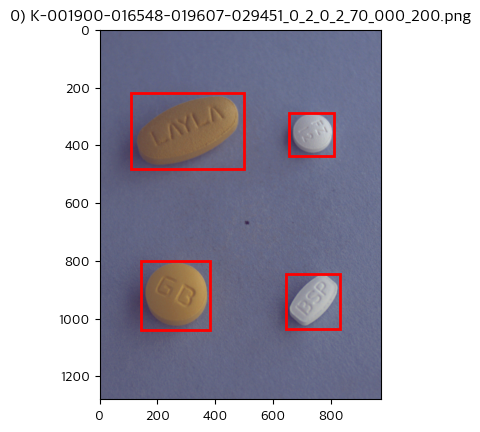

In [ ]:
# 육안 식별 오류치 파악

import torchvision
import matplotlib.patches as patches
import json
from IPython import display

index = 0

with open(err_txt_path, "r", encoding="utf-8") as f:
    err_image_paths = f.read().split()


# for image_path in err_image_paths:
#     del FULL_DICT[image_path]


while index < len(FULL_DICT):

    image_path = list(FULL_DICT.keys())[index]
    
    bbox = []

    for annot_path in FULL_DICT[image_path]:
        with open(os.path.join(ANNOT_DIR, annot_path), 'r', encoding='utf-8') as f:
            json_data = json.load(f)

        bbox.append({"bbox": json_data["annotations"][0]["bbox"],
                    "label": json_data["images"][0]["drug_N"]
                    })

    image = torchvision.io.read_image(os.path.join(IMAGE_DIR, image_path)).permute(1,2,0)


    fig, ax = plt.subplots()

    plt.title(f"{index}) {image_path}")
    plt.imshow(image)

    for bbox_dict in bbox:
        x, y, w, h = bbox_dict["bbox"][0], bbox_dict["bbox"][1], bbox_dict["bbox"][2], bbox_dict["bbox"][3]
        rectangle = patches.Rectangle((x, y), w, h, color="red", fill=False, linewidth=2)
        ax.add_patch(rectangle)

    plt.show()


    button = input("0번으로 종료 / enter로 넘어가기 / 1번으로 에러 저장")

    if button == "":
        display.clear_output(wait=True)
        display.display(plt.gcf())
        index += 1

    elif button == "0":
        break

    elif button == "1":
        err_image_paths.append(image_path.split("train_images/")[1])
        display.clear_output(wait=True)
        display.display(plt.gcf())
        index += 1

with open(err_txt_path, "w", encoding="utf-8") as f:
    for item in err_image_paths:
        f.write(item + "\n")

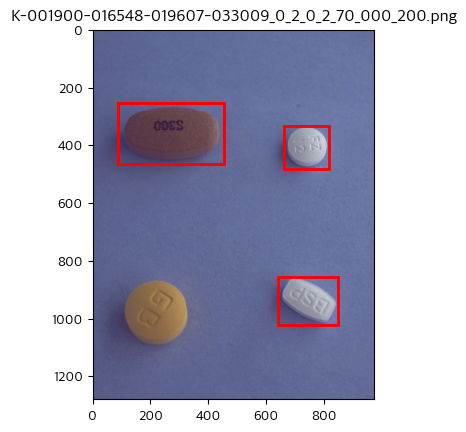

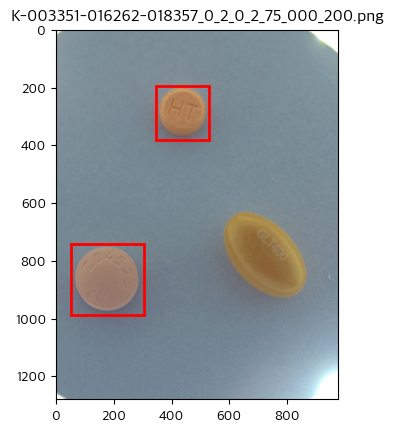

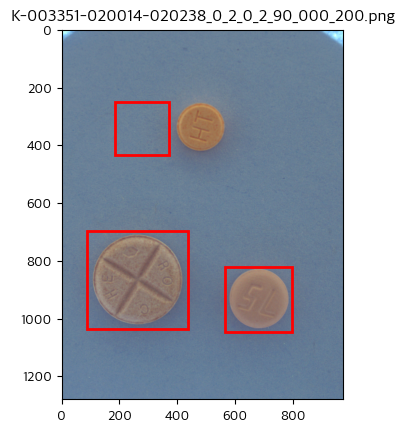

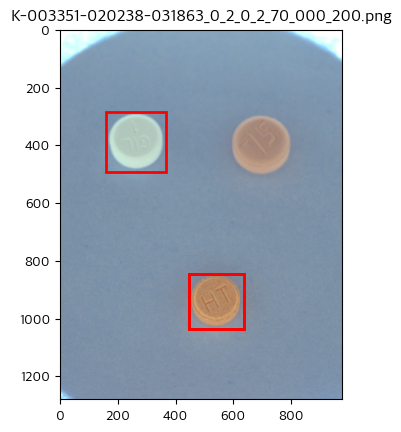

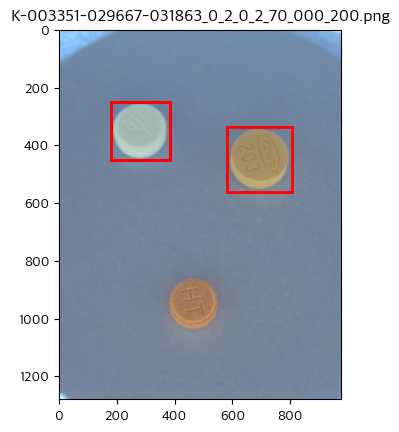

In [60]:
# 에러 이미지 출력

for img in err_image_paths:
    sample_bbox = []

    for annot_path in FULL_DICT[img]:
        with open(os.path.join(ANNOT_DIR, annot_path), 'r', encoding='utf-8') as f:
            json_data = json.load(f)
        sample_bbox.append({
                        "bbox": json_data["annotations"][0]["bbox"],
                        "label": json_data["images"][0]["drug_N"]
                        })

    image = torchvision.io.read_image(os.path.join(IMAGE_DIR, img)).permute(1,2,0)

    fig, ax = plt.subplots()

    plt.title(f"{img}")
    plt.imshow(image)

    for bbox_dict in sample_bbox:
        x, y, w, h = bbox_dict["bbox"][0], bbox_dict["bbox"][1], bbox_dict["bbox"][2], bbox_dict["bbox"][3]
        rectangle = patches.Rectangle((x, y), w, h, color="red", fill=False, linewidth=2)
        ax.add_patch(rectangle)

    plt.show()

In [ ]:

import json

FINAL_DICT = {}

# FULL_DICT 더하기
try:
    with open(full_dict_path, "r", encoding="utf-8") as f:
        FULL_DICT = json.load(f)
except:
    pass

for key, value in FULL_DICT.items():
    a = os.path.join(IMAGE_DIR, key)
    tmp_list = []
    for pa in value:
        tmp_list.append(os.path.join(ANNOT_DIR, pa))
    FINAL_DICT[a] = tmp_list


# err_image_paths 빼기
try:
    with open(err_txt_path, "r", encoding="utf-8") as f:
        err_image_paths = f.read().split()
    for err in err_image_paths:
        a = os.path.join(IMAGE_DIR, err)
        del FINAL_DICT[a]
except:
    pass


# FIXED_DICT 더하기
try:
    with open(fixed_dict_path, "r", encoding="utf-8") as f:
        FIXED_DICT = json.load(f)
    for key, value in FIXED_DICT:
        a = os.path.join(IMAGE_DIR, key)
        tmp_list = []
        for pa in value:
            tmp_list.append(os.path.join(ANNOT_DIR, pa))
        FINAL_DICT[a] = tmp_list
except:
    pass


for image_path, annot_paths in FINAL_DICT.items():

    tmp_list = []

    for path in annot_paths:
        bbox = []
        with open(path, "r", encoding="utf-8") as f:
            json_data = json.load(f)

        xywh_bbox = json_data["annotations"][0]["bbox"]

        tmp_list.append({"bbox": xywh_bbox,
                        "label": json_data["categories"][0]["id"]})
        
    FINAL_DICT[image_path] = tmp_list

215